Boosting Practice Teach for Galvinize
====================

Outline:

  - Opening example.
  - Outline.
  - You Could Have Invented Gradient Boosting.
  - Practical Gradient Boosting.
  - AdaBoost.
  
  
  Originally created by Matt Drury

Opening Example
--------------

Boosting is a stunningly powerful, general purpose, off-the-shelf machine learning algorithm.

Allstate ran three Kaggle competitions, the winners of all three used Gradient Boosting as thier core learning algorithm.

In [60]:
%matplotlib inline

import os
import numpy as np
import numpy.random as rand
from sklearn.ensemble import (GradientBoostingRegressor, 
                              GradientBoostingClassifier, 
                              AdaBoostClassifier,
                              RandomForestClassifier)
from sklearn.svm import SVC
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split, KFold
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('bmh')

from pylab import rcParams
rcParams['figure.figsize'] = (8.0, 6.0)

from IPython.display import HTML

if not os.path.exists("./plots"):
    os.mkdir("./plots")


In [61]:
# Simple helper functions
to_column = lambda x: x.reshape((x.shape[0], 1))

## Boosting for regression.

In [62]:
N = 500
N_ESTIMATORS = 500

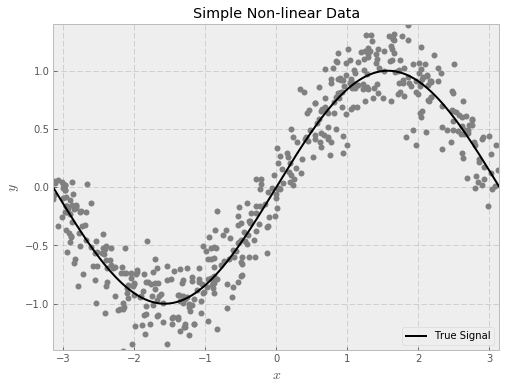

In [63]:
# Generate some data from a simple noiseless function
f = lambda x: np.sin(x)
x = np.linspace(-np.pi, np.pi, num=250)
y = f(x)

xs = rand.uniform(-np.pi, np.pi, N)
ys = f(xs) + rand.normal(0, 0.20, N)

def plot_truth():
    plt.plot(x, y, color = 'black', label="True Signal")
    plt.xlim([-np.pi, np.pi]); plt.ylim([-1.4, 1.4])
    
def plot_data():
    plt.plot(xs, ys, 'o', color='grey', markeredgewidth=0)
    
plot_data()
plot_truth()
plt.title('Simple Non-linear Data')
plt.xlabel('$x$', fontsize=14); plt.ylabel('$y$', fontsize=14)
plt.legend(loc="lower right")

plt.savefig('plots/sin-with-data.png', bbox_inches='tight')

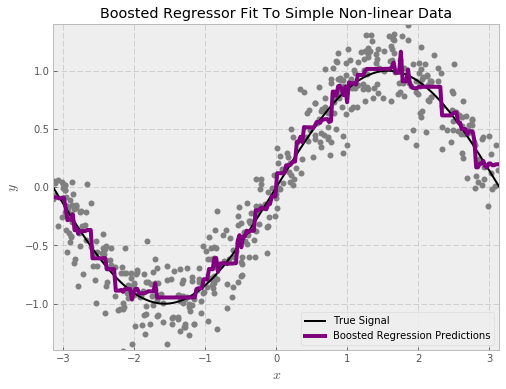

In [64]:
# Fit a gradient boosted regressor to this function and plot both the functiona and f

model = GradientBoostingRegressor(learning_rate=0.01, n_estimators=N_ESTIMATORS, max_depth=3)
model.fit(to_column(xs), ys)

y_hat = model.predict(to_column(x))

plot_data()
plot_truth()
plt.plot(x, y_hat, color='purple', linewidth=4, label="Boosted Regression Predictions")

plt.title('Boosted Regressor Fit To Simple Non-linear Data')
plt.xlabel('$x$', fontsize=14); plt.ylabel('$y$', fontsize=14)
plt.legend(loc="lower right")

plt.savefig('plots/sin-with-data-and-booster.png', dpi=400, bbox_inches='tight')

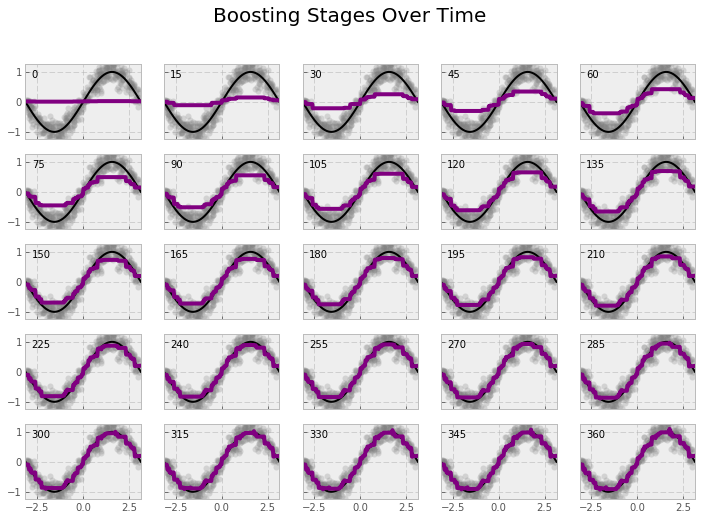

In [65]:
# Plot the partial sums of the weak learners to see what is going on.
# The point: the model learns gradually!

models = list(model.staged_predict(x.reshape(250, 1)))
fig, axes = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, 
                         figsize=(12.0, 8.0))

for i, ax in enumerate(axes.flatten()):
    ax.plot(xs, ys, 'o', color='grey', markeredgewidth=0, alpha=0.25)
    l1 = ax.plot(x, y, color = 'black')
    l2 = ax.plot(x, models[15*i], color="purple", linewidth=4)
    ax.text(-2.8, 0.8, str(15*i))
    
plt.xlim(-np.pi, np.pi); plt.ylim([-1.25, 1.25])    
plt.suptitle("Boosting Stages Over Time", fontsize=20)

plt.savefig('plots/boosting-over-time-multiple-plots.png', dpi=400, bbox_inches='tight')

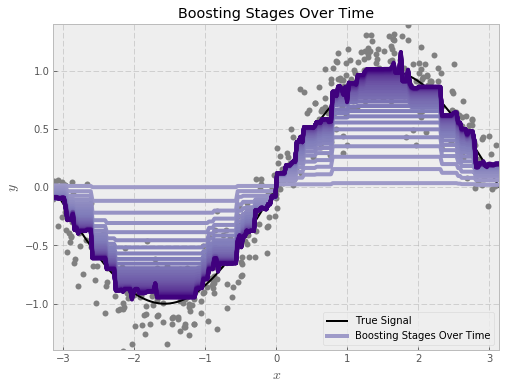

In [66]:
plot_data()
plot_truth()

label = "Boosting Stages Over Time"
for i, pred in enumerate(model.staged_predict(to_column(x))):
    if i % 15 == 1:
        plt.plot(x, pred, color=plt.cm.Purples(float(i) / 1000 + 0.5), linewidth=4,
                label=label)
        label = None
        
plt.legend(loc="lower right")
plt.xlabel('$x$', fontsize=14); plt.ylabel('$y$', fontsize=14)
plt.title("Boosting Stages Over Time")

plt.savefig('plots/boosting-over-time-single-plot.png', bbox_inches='tight')

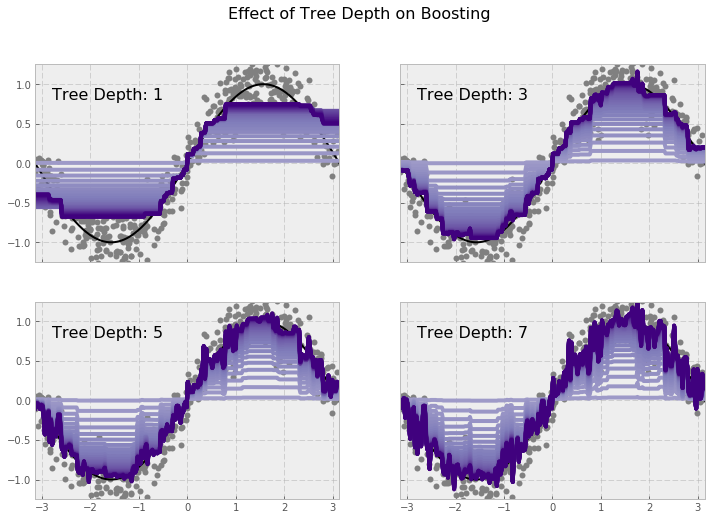

In [67]:
# Effect of changing tree depth
tree_depths = [1, 3, 5, 7]

models = [GradientBoostingRegressor(learning_rate=0.01, n_estimators=N_ESTIMATORS, max_depth=td) 
          for td in tree_depths]
for model in models:
    model.fit(to_column(xs), ys)
    
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, 
                         figsize=(12.0, 8.0))

for i, (depth, ax) in enumerate(zip(tree_depths, axes.flatten())):
    ax.plot(xs, ys, 'o', color='grey', markeredgewidth=0)
    ax.plot(x, y, color = 'black', label="True Signal")
    for j, pred in enumerate(models[i].staged_predict(to_column(x))):
        if j % 15 == 1:
            ax.plot(x, pred, color=plt.cm.Purples(float(j) / 1000 + 0.5), linewidth=4)
    ax.text(-2.8, 0.8, "Tree Depth: " + str(depth), fontsize=16)
    
plt.suptitle("Effect of Tree Depth on Boosting", fontsize=16)
plt.xlim(-np.pi, np.pi); plt.ylim([-1.25, 1.25])
plt.savefig('plots/sin-changing-depth.png', bbox_inches='tight')

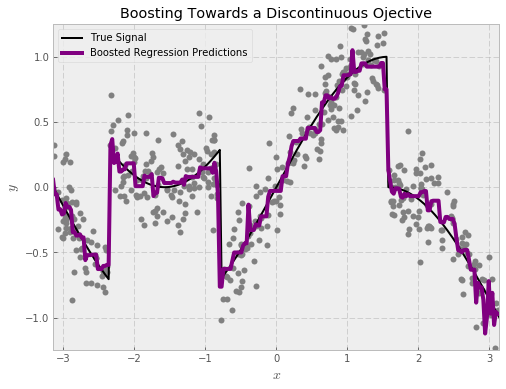

In [68]:
# Boosting can even handle complex, discontinuous loss functions

f_discontinuous = lambda x: f(x) + (x >= -0.75*np.pi)*(x <= -0.25*np.pi) - (x >= 0.5*np.pi)
y_discontinuous = f_discontinuous(x)
ys_discontinuous = f_discontinuous(xs) + rand.normal(0, 0.20, N)

def plot_discontinuous_truth():
    plt.plot(x, y_discontinuous, color = 'black', label="True Signal")
    plt.xlim(-np.pi, np.pi); plt.ylim([-1.25, 1.25])
    
def plot_discontinuous_data():
    plt.plot(xs, ys_discontinuous, 'o', color='grey', markeredgewidth=0)

model = GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000)
model.fit(to_column(xs), ys_discontinuous)

y_hat = model.predict(to_column(x))

plot_discontinuous_data()
plot_discontinuous_truth()
plt.plot(x, y_hat, color='purple', linewidth=4, label="Boosted Regression Predictions")
plt.title("Boosting Towards a Discontinuous Ojective")
plt.xlabel('$x$', fontsize=14); plt.ylabel('$y$', fontsize=14)
plt.legend(loc="upper left")

plt.savefig('plots/broken-sin-with-booster.png', bbox_inches='tight')

## Boosting to Residuals

In [69]:
N = 12

np.random.seed(seed=200)

# For plotting
f = lambda x: np.sin(x)
x = np.linspace(-np.pi, np.pi, num=250)
y = f(x)

# Training Data
xs = np.linspace(-np.pi, np.pi, 12)
ys = f(xs) + rand.normal(0, 0.20, N)

mu = np.mean(ys)

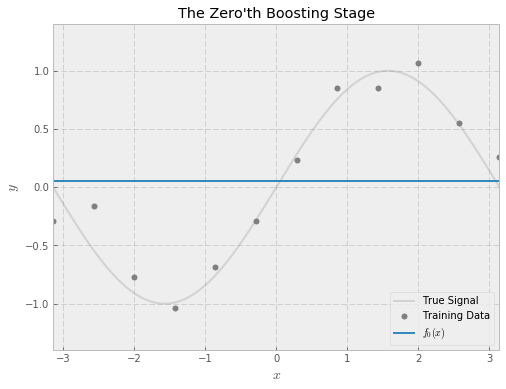

In [70]:
plt.plot(x, y, '-', color='grey', alpha=0.25, label='True Signal')
plt.plot(xs, ys, 'o', markeredgewidth=0, color="grey", label='Training Data')
plt.plot(xs, np.repeat(mu, N), label="$f_0(x)$")
plt.xlim([-np.pi, np.pi]); plt.ylim([-1.4, 1.4])

plt.title('The Zero\'th Boosting Stage')
plt.xlabel('$x$', fontsize=14); plt.ylabel('$y$', fontsize=14)
plt.legend(loc="lower right")

plt.savefig('plots/zeroth-boosting-stage.png', bbox_inches='tight')

In [71]:
# Fit the boosted regression for later
model_no_lr = GradientBoostingRegressor(n_estimators=6, learning_rate=1.0, max_depth=2)
model_with_lr = GradientBoostingRegressor(n_estimators=600, learning_rate=0.01, max_depth=2)

model_no_lr.fit(to_column(xs), ys)
model_with_lr.fit(to_column(xs), ys)

model_no_lr_preds = list(model_no_lr.staged_predict(to_column(x)))
model_no_lr_preds_at_training = list(model_no_lr.staged_predict(to_column(xs)))

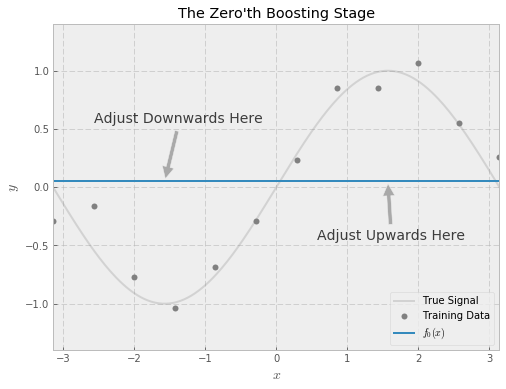

In [72]:
plt.plot(x, y, '-', color='grey', alpha=0.25, label='True Signal')
plt.plot(xs, ys, 'o', markeredgewidth=0, color="grey", label='Training Data')
plt.plot(xs, np.repeat(mu, N), label="$f_0(x)$")
plt.xlim([-np.pi, np.pi]); plt.ylim([-1.4, 1.4])

left_arrow_pos = [-np.pi / 2, mu]
plt.annotate('Adjust Downwards Here', left_arrow_pos,
              xytext=(left_arrow_pos[0] - 1, left_arrow_pos[1] + 0.5),
              arrowprops=dict(facecolor="darkgrey", shrink=0.05),
              fontsize=14,
              alpha=0.75
            )

right_arrow_pos = [np.pi / 2, mu]
plt.annotate('Adjust Upwards Here', right_arrow_pos,
              xytext=(right_arrow_pos[0] - 1, right_arrow_pos[1] - 0.5),
              arrowprops=dict(facecolor="darkgrey", shrink=0.05),
              fontsize=14,
              alpha=0.75
            )

plt.title('The Zero\'th Boosting Stage')
plt.xlabel('$x$', fontsize=14); plt.ylabel('$y$', fontsize=14)
plt.legend(loc="lower right")

plt.savefig('plots/zeroth-boosting-stage-what-to-do.png', bbox_inches='tight')

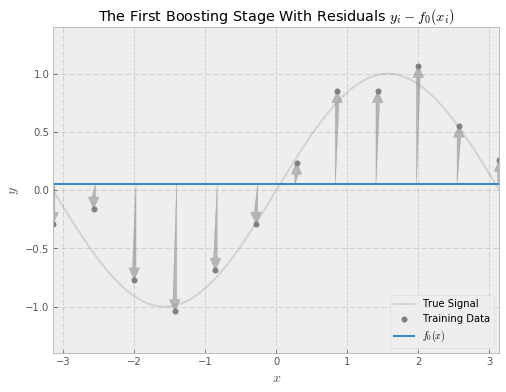

In [73]:
plt.plot(x, y, '-', color='grey', alpha=0.25, label='True Signal')
plt.plot(xs, ys, 'o', markeredgewidth=0, color="grey", label='Training Data')
plt.plot(xs, np.repeat(mu, N), label="$f_0(x)$")

for px, py in zip(xs, ys):
    plt.arrow(px, mu, 0, py - mu, color='grey', alpha=0.5,
              head_width=0.15, head_length=0.1, width=0.05,
              length_includes_head=True, label='Residuals $f_0(x) - y$')

plt.title('The First Boosting Stage With Residuals $y_i - f_0(x_i)$')
plt.xlabel('$x$', fontsize=14); plt.ylabel('$y$', fontsize=14)
plt.legend(loc="lower right")
plt.xlim([-np.pi, np.pi]); plt.ylim([-1.4, 1.4])

plt.savefig('plots/first-boosting-stage-with-residuals.png', bbox_inches='tight')

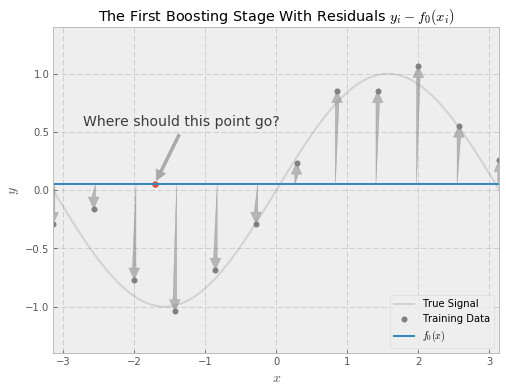

In [74]:
plt.plot(x, y, '-', color='grey', alpha=0.25, label='True Signal')
plt.plot(xs, ys, 'o', markeredgewidth=0, color="grey", label='Training Data')
plt.plot(xs, np.repeat(mu, N), label="$f_0(x)$")

for px, py in zip(xs, ys):
    plt.arrow(px, mu, 0, py - mu, color='grey', alpha=0.5,
              head_width=0.15, head_length=0.1, width=0.05,
              length_includes_head=True, label='Residuals $f_0(x) - y$')
    

    
arrow_pos = (xs[2] + (xs[3] - xs[2])/2, mu)
# I had to google the hex color name
plt.scatter([arrow_pos[0]], [arrow_pos[1]], s=35, color='#E24A33')
plt.annotate('Where should this point go?', arrow_pos,
              xytext=(arrow_pos[0] - 1, arrow_pos[1] + 0.5),
              arrowprops=dict(facecolor="darkgrey", shrink=0.05),
              fontsize=14,
              alpha=0.75
            )


plt.title('The First Boosting Stage With Residuals $y_i - f_0(x_i)$')
plt.xlabel('$x$', fontsize=14); plt.ylabel('$y$', fontsize=14)
plt.legend(loc="lower right")
plt.xlim([-np.pi, np.pi]); plt.ylim([-1.4, 1.4])

plt.savefig('plots/first-boosting-stage-with-residuals-dillema.png', bbox_inches='tight')

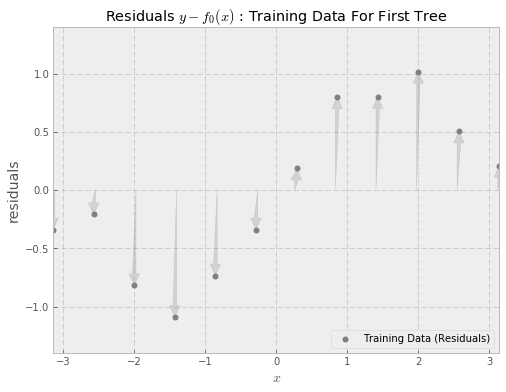

In [75]:
residuals_0 = ys - mu

plt.plot(xs, residuals_0, 'o', markeredgewidth=0, color="grey", label='Training Data (Residuals)')

for px, py in zip(xs, residuals_0):
    plt.arrow(px, 0, 0, py, color='grey', alpha=0.25,
              head_width=0.15, head_length=0.1, width=0.05,
              length_includes_head=True, label='Residuals $f_0(x) - y$')

plt.title('Residuals $y - f_0(x)$ : Training Data For First Tree')
plt.xlabel('$x$', fontsize=14); plt.ylabel('residuals', fontsize=14)
plt.legend(loc="lower right")
plt.xlim([-np.pi, np.pi]); plt.ylim([-1.4, 1.4])

plt.savefig('plots/first-boosting-stage-residual-training-set.png', bbox_inches='tight')

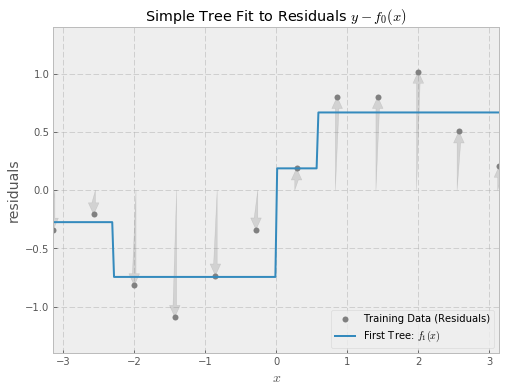

In [76]:
wl_preds_0 = model_no_lr_preds[0] - mu

plt.plot(xs, residuals_0, 'o', markeredgewidth=0, color="grey", label='Training Data (Residuals)')
plt.plot(x, wl_preds_0, label="First Tree: $f_1(x)$")

for px, py in zip(xs, residuals_0):
    plt.arrow(px, 0, 0, py, color='grey', alpha=0.25,
              head_width=0.15, head_length=0.1, width=0.05,
              length_includes_head=True, label='Residuals $f_0(x) - y$')

plt.title('Simple Tree Fit to Residuals $y - f_0(x)$')
plt.xlabel('$x$', fontsize=14); plt.ylabel('residuals', fontsize=14)
plt.legend(loc="lower right")
plt.xlim([-np.pi, np.pi]); plt.ylim([-1.4, 1.4])

plt.savefig('plots/first-boosting-stage-residuals-with-tree.png', bbox_inches='tight')

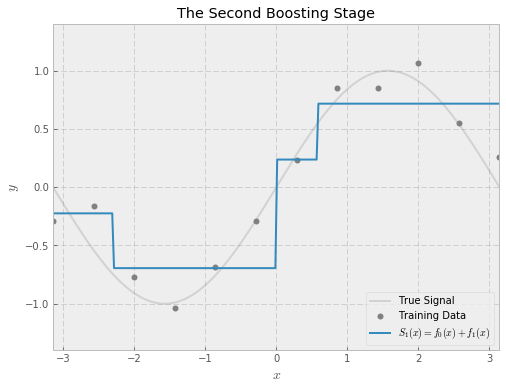

In [77]:
plt.plot(x, y, '-', color='grey', alpha=0.25, label='True Signal')
plt.plot(xs, ys, 'o', markeredgewidth=0, color="grey", label='Training Data')

plt.plot(x, model_no_lr_preds[0], label="$S_1(x) = f_0(x) + f_1(x)$")

plt.title('The Second Boosting Stage')
plt.xlabel('$x$', fontsize=14); plt.ylabel('$y$', fontsize=14)
plt.legend(loc="lower right")
plt.xlim([-np.pi, np.pi]); plt.ylim([-1.4, 1.4])

plt.savefig('plots/second-boosting-stage.png', bbox_inches='tight')

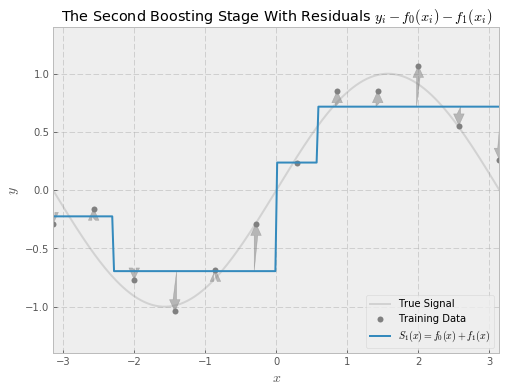

In [78]:
residuals_1 = ys - model_no_lr_preds_at_training[0]

plt.plot(x, y, '-', color='grey', alpha=0.25, label='True Signal')
plt.plot(xs, ys, 'o', markeredgewidth=0, color="grey", label='Training Data')
plt.plot(x, model_no_lr_preds[0], label="$S_1(x) = f_0(x) + f_1(x)$")

for px, py, pp in zip(xs, ys, model_no_lr_preds_at_training[0]):
    try:
        # Arrows of length zero are unhappy
        plt.arrow(px, pp, 0, py - pp,
                  color='grey', alpha=0.5,
                  head_width=0.15, head_length=0.1, width=0.05,
                  length_includes_head=True, label='Residuals $f_0(x) - y$')
    except:
        pass

plt.title('The Second Boosting Stage With Residuals $y_i - f_0(x_i) - f_1(x_i)$')
plt.xlabel('$x$', fontsize=14); plt.ylabel('$y$', fontsize=14)
plt.legend(loc="lower right")
plt.xlim([-np.pi, np.pi]); plt.ylim([-1.4, 1.4])

plt.savefig('plots/second-boosting-stage-with-residuals.png', bbox_inches='tight')

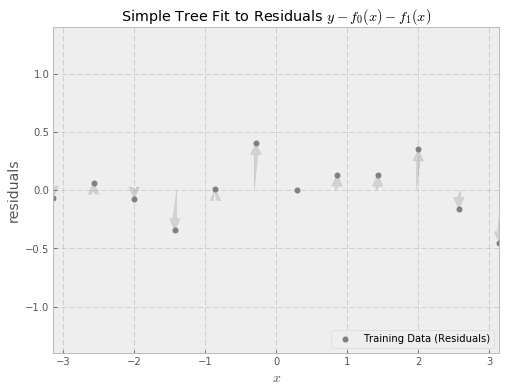

In [79]:
wl_preds_1 = model_no_lr_preds[1] - model_no_lr_preds[0]

plt.plot(xs, residuals_1, 'o', markeredgewidth=0, color="grey", label='Training Data (Residuals)')

for px, py in zip(xs, residuals_1):
    try:
        plt.arrow(px, 0, 0, py, color='grey', alpha=0.25,
                  head_width=0.15, head_length=0.1, width=0.05,
                  length_includes_head=True, label='Residuals $f_0(x) - y$')
    except:
        pass

plt.title('Simple Tree Fit to Residuals $y - f_0(x) - f_1(x)$')
plt.xlabel('$x$', fontsize=14); plt.ylabel('residuals', fontsize=14)
plt.legend(loc="lower right")
plt.xlim([-np.pi, np.pi]); plt.ylim([-1.4, 1.4])

plt.savefig('plots/second-boosting-stage-residual-training-set.png', bbox_inches='tight')

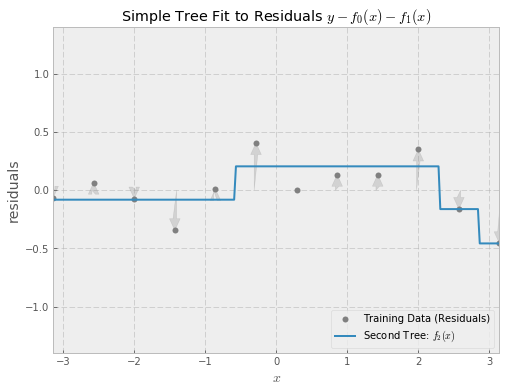

In [80]:
wl_preds_1 = model_no_lr_preds[1] - model_no_lr_preds[0]

plt.plot(xs, residuals_1, 'o', markeredgewidth=0, color="grey", label='Training Data (Residuals)')
plt.plot(x, wl_preds_1, label="Second Tree: $f_2(x)$")

for px, py in zip(xs, residuals_1):
    try:
        plt.arrow(px, 0, 0, py, color='grey', alpha=0.25,
                  head_width=0.15, head_length=0.1, width=0.05,
                  length_includes_head=True, label='Residuals $f_0(x) - y$')
    except:
        pass

plt.title('Simple Tree Fit to Residuals $y - f_0(x) - f_1(x)$')
plt.xlabel('$x$', fontsize=14); plt.ylabel('residuals', fontsize=14)
plt.legend(loc="lower right")
plt.xlim([-np.pi, np.pi]); plt.ylim([-1.4, 1.4])

plt.savefig('plots/second-boosting-stage-residuals-with-tree.png', bbox_inches='tight')

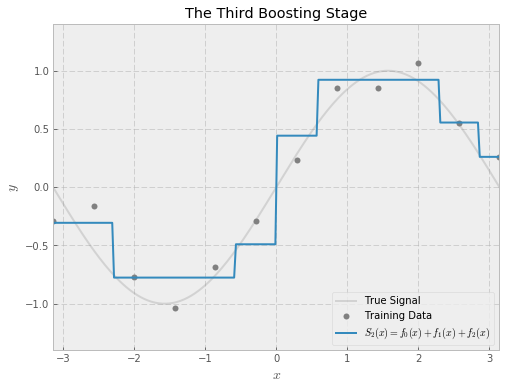

In [81]:
plt.plot(x, y, '-', color='grey', alpha=0.25, label='True Signal')
plt.plot(xs, ys, 'o', markeredgewidth=0, color="grey", label='Training Data')

plt.plot(x, model_no_lr_preds[1], label="$S_2(x) = f_0(x) + f_1(x) + f_2(x)$")

plt.title('The Third Boosting Stage')
plt.xlabel('$x$', fontsize=14); plt.ylabel('$y$', fontsize=14)
plt.legend(loc="lower right")
plt.xlim([-np.pi, np.pi]); plt.ylim([-1.4, 1.4])

plt.savefig('plots/third-boosting-stage.png', bbox_inches='tight')

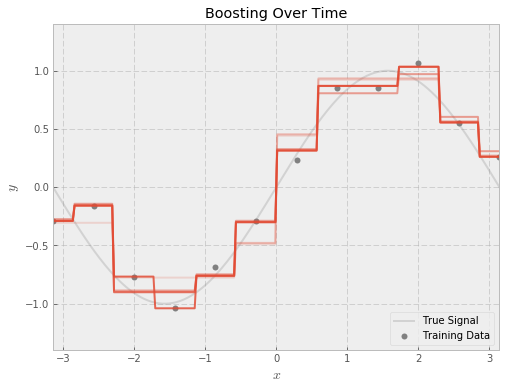

In [82]:
plt.plot(x, y, '-', color='grey', alpha=0.25, label='True Signal')
plt.plot(xs, ys, 'o', markeredgewidth=0, color="grey", label='Training Data')

for i, py in enumerate(model_no_lr.staged_predict(to_column(x))):
    plt.plot(x, py, color='#E24A33', alpha=(float(i)/model_no_lr.n_estimators))

plt.title('Boosting Over Time')
plt.xlabel('$x$', fontsize=14); plt.ylabel('$y$', fontsize=14)
plt.legend(loc="lower right")
plt.xlim([-np.pi, np.pi]); plt.ylim([-1.4, 1.4])

plt.savefig('plots/simple-boosting-over-time.png', bbox_inches='tight')

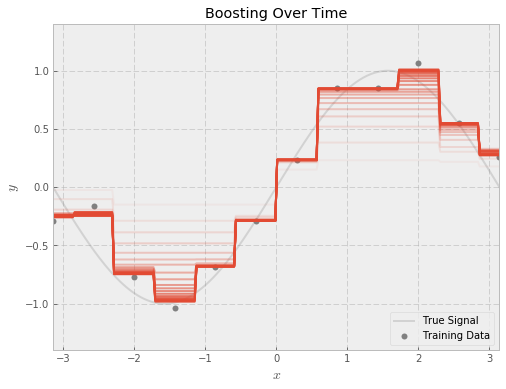

In [83]:
plt.plot(x, y, '-', color='grey', alpha=0.25, label='True Signal')
plt.plot(xs, ys, 'o', markeredgewidth=0, color="grey", label='Training Data')

for i, py in enumerate(model_with_lr.staged_predict(to_column(x))):
    if i % 30 == 0:
        plt.plot(x, py, color='#E24A33', alpha=(float(i)/model_with_lr.n_estimators))


plt.title('Boosting Over Time')
plt.xlabel('$x$', fontsize=14); plt.ylabel('$y$', fontsize=14)
plt.legend(loc="lower right")
plt.xlim([-np.pi, np.pi]); plt.ylim([-1.4, 1.4])

plt.savefig('plots/simple-boosting-over-time-learning-rate.png', bbox_inches='tight')

## Boosting for Classification

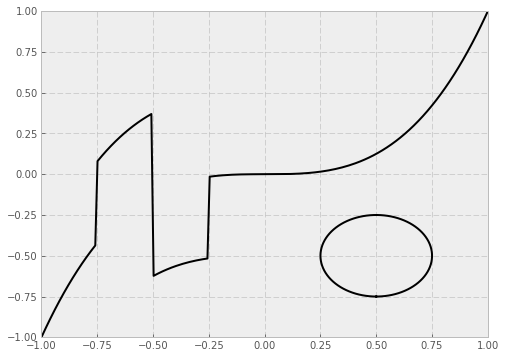

In [84]:
cubic_boundary = lambda t: (t, t**3 + 0.5*(t > -0.75)*(t < -0.5) - 0.5*(t > -0.5)*(t < -0.25))
circular_boundary = lambda t: (0.25*np.sin(t) + 0.5, 0.25*np.cos(t) - 0.5)

t_cubic = np.linspace(-1, 1, 200)
x_cubic, y_cubic = cubic_boundary(t_cubic)
t_circle = np.linspace(-np.pi, np.pi, 200)
x_circle, y_circle = circular_boundary(t_circle)

def plot_classification_boundary():
    plt.plot(x_cubic, y_cubic, color="black", label="True Decision Boundary")
    plt.plot(x_circle, y_circle, color="black")
    plt.xlim([-1, 1]); plt.ylim([-1, 1])
    
plot_classification_boundary()    

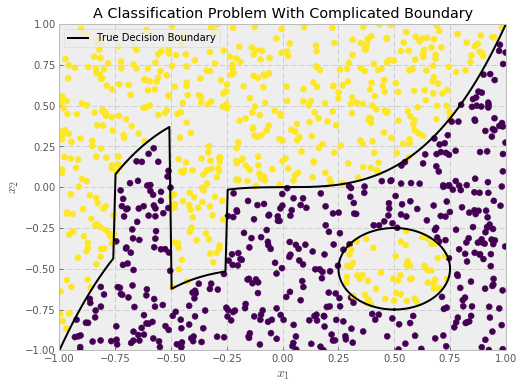

In [85]:
is_above_cubic = lambda x, y: cubic_boundary(x)[1] < y
is_inside_circle = lambda x, y: (x - 0.5)**2 + (y + 0.5)**2 < 0.25**2
is_positive_class = lambda x, y: np.logical_or(is_above_cubic(x, y), is_inside_circle(x, y))

N = 1000

xs = rand.uniform(-1, 1, N)
ys = rand.uniform(-1, 1, N)
label = is_positive_class(xs, ys)

X = np.vstack([xs, ys]).T

def plot_data():
    plt.scatter(xs, ys, c=label, marker='o')

plot_data()
plot_classification_boundary()
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
plt.title("A Classification Problem With Complicated Boundary")
plt.legend(loc="upper left")

plt.savefig('plots/classification-boundary-with-data.png', bbox_inches='tight')

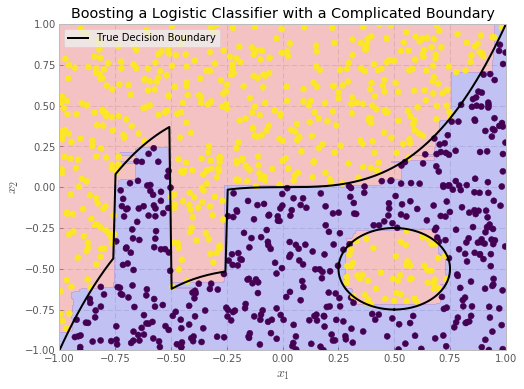

In [86]:
N_ESTIMATORS = 1000

model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=N_ESTIMATORS, min_samples_leaf=10)
model.fit(X, label)

gx = np.linspace(-1, 1, 200)
gy = np.linspace(-1, 1, 200)
meshx, meshy = np.meshgrid(gx, gy)
grid = np.vstack([meshx.flatten(), meshy.flatten()]).T

p_hat = model.predict_proba(grid)[:, 0].flatten()
plt.contourf(meshx, meshy, p_hat.reshape(meshx.shape), 
             levels=np.linspace(0, 1, 3), 
             alpha=0.4, cmap=plt.cm.bwr_r,
             label="Fit Decision Boundary")
plot_data()
plot_classification_boundary()
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
plt.title("Boosting a Logistic Classifier with a Complicated Boundary")
plt.legend(loc="upper left")

plt.savefig('plots/classification-boundary-with-booster.png', bbox_inches='tight')

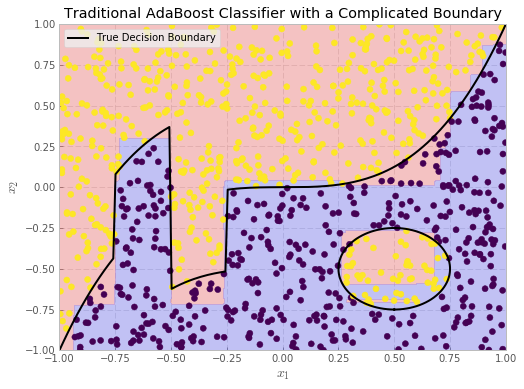

In [87]:
model = AdaBoostClassifier(learning_rate=0.01, n_estimators=N_ESTIMATORS*8)
model.fit(X, label)

gx = np.linspace(-1, 1, 200)
gy = np.linspace(-1, 1, 200)
meshx, meshy = np.meshgrid(gx, gy)
grid = np.vstack([meshx.flatten(), meshy.flatten()]).T

p_hat = model.predict_proba(grid)[:, 0].flatten()
plt.contourf(meshx, meshy, p_hat.reshape(meshx.shape), 
             levels=np.linspace(0, 1, 3), 
             alpha=0.4, cmap=plt.cm.bwr_r,
             label="Fit Decision Boundary")
plot_data()
plot_classification_boundary()
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
plt.title("Traditional AdaBoost Classifier with a Complicated Boundary")
plt.legend(loc="upper left")

plt.savefig('plots/classification-boundary-with-ada-booster.png', bbox_inches='tight')

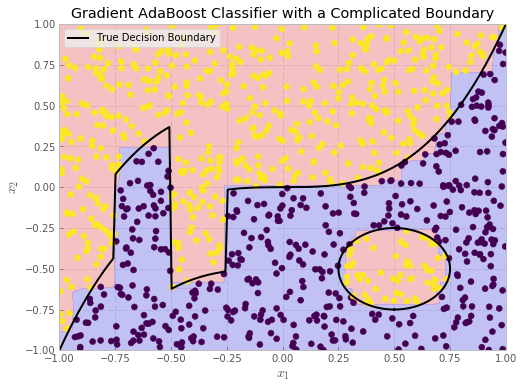

In [88]:
model = GradientBoostingClassifier(loss='exponential',
                                   learning_rate=0.01, n_estimators=N_ESTIMATORS, min_samples_leaf=10)
model.fit(X, label)

gx = np.linspace(-1, 1, 200)
gy = np.linspace(-1, 1, 200)
meshx, meshy = np.meshgrid(gx, gy)
grid = np.vstack([meshx.flatten(), meshy.flatten()]).T

p_hat = model.predict_proba(grid)[:, 0].flatten()
plt.contourf(meshx, meshy, p_hat.reshape(meshx.shape), 
             levels=np.linspace(0, 1, 3), 
             alpha=0.4, cmap=plt.cm.bwr_r,
             label="Fit Decision Boundary")
plot_data()
plot_classification_boundary()
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
plt.title("Gradient AdaBoost Classifier with a Complicated Boundary")
plt.legend(loc="upper left")

plt.savefig('plots/classification-boundary-with-ada-gradient-booster.png', bbox_inches='tight')

## A more complicated example with class mixing.

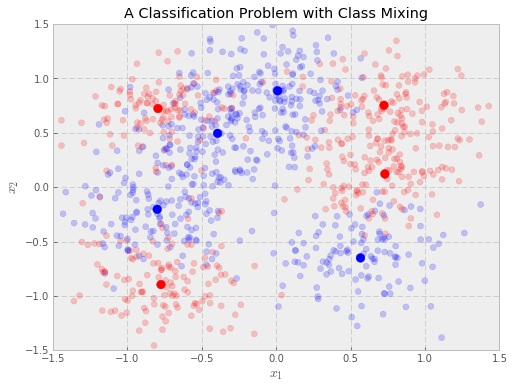

In [89]:
N = 1000
np.random.seed(seed=210)

class_centers_xs = rand.uniform(-1, 1, 8)
class_centers_ys = rand.uniform(-1, 1, 8)

class_idxs = rand.randint(0, 8, size=N)
label = class_idxs / 4

X = np.array([rand.multivariate_normal((x, y), 0.075*np.array([[1, 0], [0, 1]]), size=1) 
              for x, y in zip([class_centers_xs[idx] for idx in class_idxs], 
                              [class_centers_ys[idx] for idx in class_idxs])]).squeeze()
Xx = X[:, 0]
Xy = X[:, 1]

colors = np.array(['blue', 'red'])

def plot_mixed_data():
    plt.scatter(Xx, Xy, color=colors[label], alpha=0.2)
    plt.scatter(class_centers_xs, class_centers_ys, marker='o', s=75, 
                color=colors[[0, 0, 0, 0, 1, 1, 1, 1]])
    
plot_mixed_data()
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
plt.title("A Classification Problem with Class Mixing")
plt.legend(loc="upper left")
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])

plt.savefig('plots/classification-mixed.png', bbox_inches='tight')

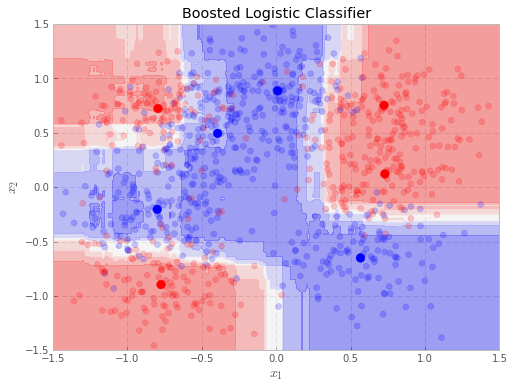

In [90]:
model = GradientBoostingClassifier(learning_rate=0.01,
                                   n_estimators=500,
                                   min_samples_leaf=5,
                                   subsample=0.5)
model.fit(X, label)

gx = np.linspace(-1.5, 1.5, 500)
gy = np.linspace(-1.5, 1.5, 500)
meshx, meshy = np.meshgrid(gx, gy)
grid = np.vstack([meshx.flatten(), meshy.flatten()]).T

p_hat = model.predict_proba(grid)[:, 0].flatten()
plt.contourf(meshx, meshy, p_hat.reshape(meshx.shape), 
             levels=np.linspace(0, 1, 8), 
             alpha=0.4, cmap=plt.cm.bwr_r,
             label="Fit Decision Boundary")
plot_mixed_data()
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
plt.title("Boosted Logistic Classifier")
plt.legend(loc="upper left")
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])

plt.savefig('plots/classification-mixed-logistic-boosting.png', bbox_inches='tight')

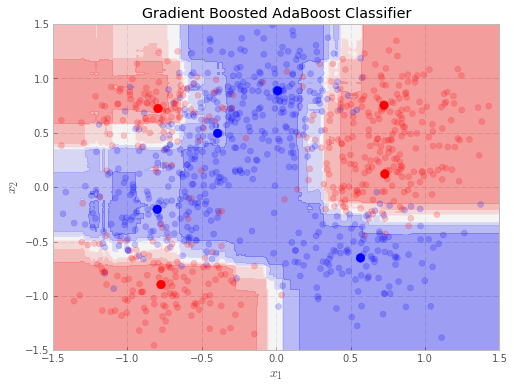

In [91]:
model = GradientBoostingClassifier(loss='exponential',
                                   learning_rate=0.01,
                                   n_estimators=500,
                                   min_samples_leaf=5,
                                   subsample=0.5)
model.fit(X, label)

gx = np.linspace(-1.5, 1.5, 500)
gy = np.linspace(-1.5, 1.5, 500)
meshx, meshy = np.meshgrid(gx, gy)
grid = np.vstack([meshx.flatten(), meshy.flatten()]).T

p_hat = model.predict_proba(grid)[:, 0].flatten()
plt.contourf(meshx, meshy, p_hat.reshape(meshx.shape), 
             levels=np.linspace(0, 1, 8), 
             alpha=0.4, cmap=plt.cm.bwr_r,
             label="Fit Decision Boundary")
plot_mixed_data()
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
plt.title("Gradient Boosted AdaBoost Classifier")
plt.legend(loc="upper left")
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])

plt.savefig('plots/classification-mixed-ada-gradient-boosting.png', bbox_inches='tight')

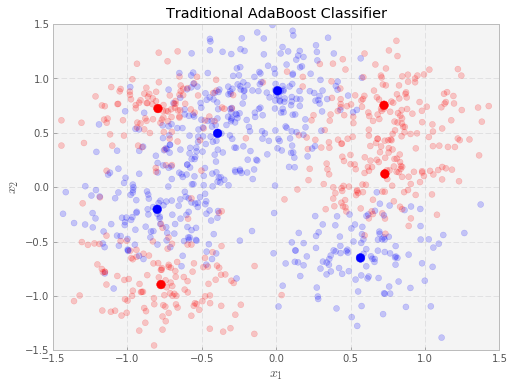

In [92]:
model = AdaBoostClassifier(learning_rate=0.01, n_estimators=4*500)
model.fit(X, label)

gx = np.linspace(-1.5, 1.5, 500)
gy = np.linspace(-1.5, 1.5, 500)
meshx, meshy = np.meshgrid(gx, gy)
grid = np.vstack([meshx.flatten(), meshy.flatten()]).T

p_hat = model.predict_proba(grid)[:, 0].flatten()
plt.contourf(meshx, meshy, p_hat.reshape(meshx.shape), 
             levels=np.linspace(0, 1, 8), 
             alpha=0.4, cmap=plt.cm.bwr_r,
             label="Fit Decision Boundary")
plot_mixed_data()
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
plt.title("Traditional AdaBoost Classifier")
plt.legend(loc="upper left")
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])

plt.savefig('plots/classification-mixed-ada-traditional-boosting.png', bbox_inches='tight')

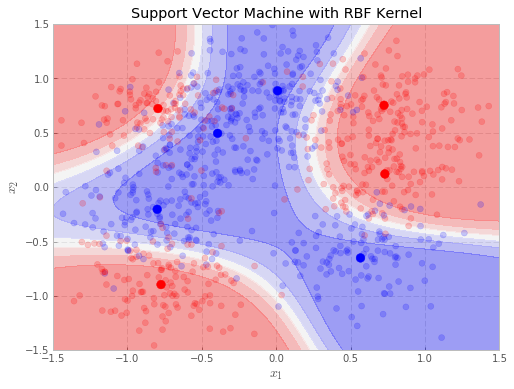

In [93]:
model = SVC(C=0.5, probability=True)

model.fit(X, label)

gx = np.linspace(-1.5, 1.5, 500)
gy = np.linspace(-1.5, 1.5, 500)
meshx, meshy = np.meshgrid(gx, gy)
grid = np.vstack([meshx.flatten(), meshy.flatten()]).T

p_hat = model.predict_proba(grid)[:, 0].flatten()
plt.contourf(meshx, meshy, p_hat.reshape(meshx.shape), 
             levels=np.linspace(0, 1, 8), 
             alpha=0.4, cmap=plt.cm.bwr_r,
             label="Fit Decision Boundary")
plot_mixed_data()
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
plt.title("Support Vector Machine with RBF Kernel")
plt.legend(loc="upper left")
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])

plt.savefig('plots/classification-mixed-svm.png', bbox_inches='tight')

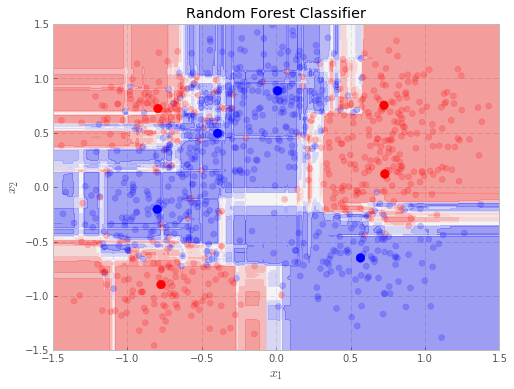

In [94]:
model = RandomForestClassifier(n_estimators=5000, n_jobs=6, max_features=2)

model.fit(X, label)

gx = np.linspace(-1.5, 1.5, 500)
gy = np.linspace(-1.5, 1.5, 500)
meshx, meshy = np.meshgrid(gx, gy)
grid = np.vstack([meshx.flatten(), meshy.flatten()]).T

p_hat = model.predict_proba(grid)[:, 0].flatten()
plt.contourf(meshx, meshy, p_hat.reshape(meshx.shape), 
             levels=np.linspace(0, 1, 8), 
             alpha=0.4, cmap=plt.cm.bwr_r,
             label="Fit Decision Boundary")
plot_mixed_data()
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
plt.title("Random Forest Classifier")
plt.legend(loc="upper left")
plt.xlim([-1.5, 1.5])
plt.ylim([-1.5, 1.5])

plt.savefig('plots/classification-mixed-random-forest.png', bbox_inches='tight')

# Boston Data Set

In [95]:
## Regression on the boston data set
N_ESTIMATORS = 3000

boston = datasets.load_boston()
X, y, names = boston['data'], boston['target'], boston['feature_names']

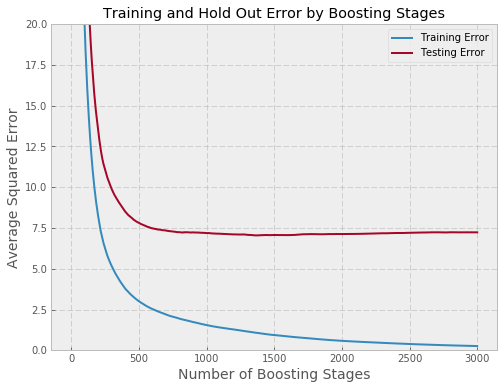

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

model = GradientBoostingRegressor(n_estimators=N_ESTIMATORS, learning_rate=0.01)
model.fit(X_train, y_train)

train_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(model.staged_predict(X_train)):
    train_score[i] = model.loss_(y_train, y_pred)

test_score = np.zeros(N_ESTIMATORS)
for i, y_pred in enumerate(model.staged_predict(X_test)):
    test_score[i] = model.loss_(y_test, y_pred)
    
plt.plot(np.arange(N_ESTIMATORS) + 1, train_score,
        label="Training Error")
plt.plot(np.arange(N_ESTIMATORS) + 1, test_score,
        label="Testing Error")
plt.title("Training and Hold Out Error by Boosting Stages")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)
plt.legend(loc="upper right")
plt.ylim([0, 20])

plt.savefig('plots/training-and-testing-error.png', bbox_inches='tight')

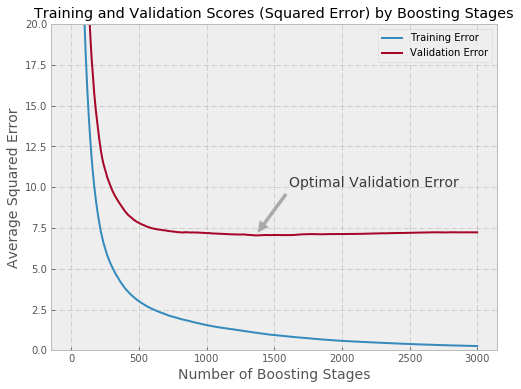

In [97]:
# Estimating the optimal number of boosters using a validation set

optimal_n_trees = np.argmin(test_score)
optimal_score = test_score[optimal_n_trees]

plt.plot(np.arange(N_ESTIMATORS) + 1, train_score,
        label="Training Error")
plt.plot(np.arange(N_ESTIMATORS) + 1, test_score,
        label="Validation Error")

optimal_point = (optimal_n_trees, optimal_score)
plt.annotate('Optimal Validation Error', optimal_point,
              xytext=(optimal_point[0] + 250, optimal_point[1] + 3),
              arrowprops=dict(facecolor="darkgrey", shrink=0.05),
              fontsize=14,
              alpha=0.75
            )

plt.title("Training and Validation Scores (Squared Error) by Boosting Stages")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)
plt.legend(loc="upper right")
plt.ylim([0, 20])

plt.savefig('plots/training-and-testing-error-with-optima.png', bbox_inches='tight')

In [98]:
# Fit a model with optimal values to look at various diagnostic plots

model = GradientBoostingRegressor(n_estimators=optimal_n_trees, learning_rate=0.01)
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=1362,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [99]:
np.sum(model.feature_importances_)

0.99999999999999967

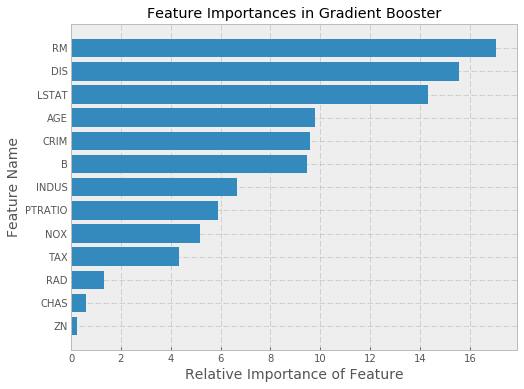

In [100]:
feature_importances = 100*model.feature_importances_ / np.sum(model.feature_importances_)
feature_importances, feature_names, feature_idxs = zip(*sorted(zip(feature_importances, names, range(len(names)))))

width = 0.8

idx = np.arange(len(names))
plt.barh(idx, feature_importances, align='center')
plt.yticks(idx, feature_names)

plt.title("Feature Importances in Gradient Booster")
plt.xlabel('Relative Importance of Feature', fontsize=14)
plt.ylabel('Feature Name', fontsize=14)

plt.savefig('plots/feature-importances.png', bbox_inches='tight')

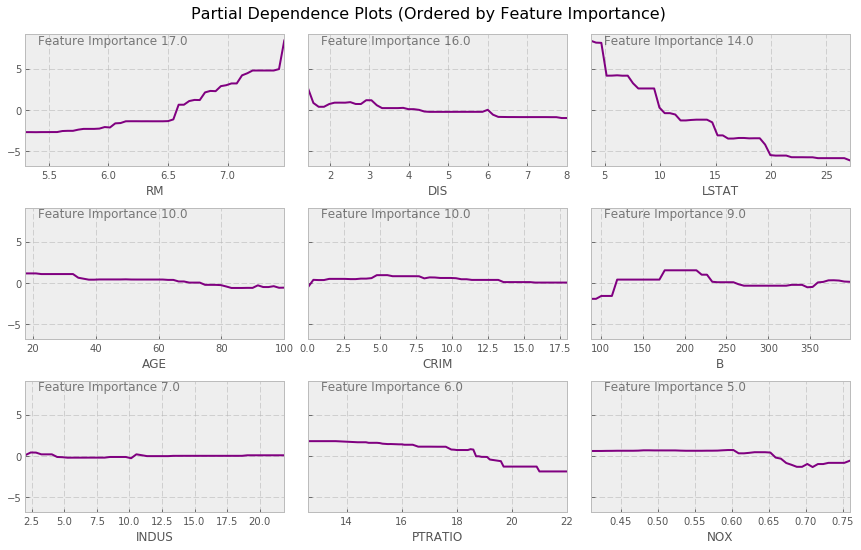

In [101]:
# This kind of sucks
N_COLS = 3
fimportances = list(reversed(feature_importances))
fnames = list(reversed(feature_names))

pd_plots = [partial_dependence(model, target_feature, X=X_train, grid_resolution=50)
            for target_feature in feature_idxs]
pd_plots = list(reversed(zip([pdp[0][0] for pdp in pd_plots], [pdp[1][0] for pdp in pd_plots])))

fig, axes = plt.subplots(nrows=3, ncols=N_COLS, sharey=True, 
                         figsize=(12.0, 8.0))

for i, (y_axis, x_axis) in enumerate(pd_plots[0:(3*N_COLS)]):
    ax = axes[i/N_COLS, i%N_COLS]
    ax.plot(x_axis, y_axis, color="purple")
    ax.set_xlim([np.min(x_axis), np.max(x_axis)])
    text_x_pos = np.min(x_axis) + 0.05*(np.max(x_axis) - np.min(x_axis))
    ax.text(text_x_pos, 8,
            "Feature Importance " + str(round(fimportances[i], )), 
            fontsize=12, alpha=0.5)
    ax.set_xlabel(fnames[i])
    
plt.suptitle("Partial Dependence Plots (Ordered by Feature Importance)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.savefig('plots/patial-dependence-plots.png', bbox_inches='tight')

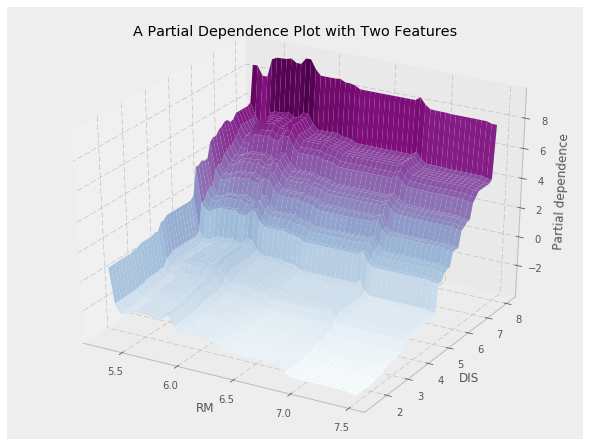

In [102]:
# Two varaibles at once
fidxs = list(reversed(feature_idxs))
pdp, (x_axis, y_axis) = partial_dependence(model, (fidxs[0], fidxs[1]),
                                           X=X_train, grid_resolution=50)

fig = plt.figure()
plt.style.use('bmh')

XX, YY = np.meshgrid(x_axis, y_axis)
Z = pdp.T.reshape(XX.shape)
ax = Axes3D(fig)
ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu)
ax.view_init(elev=30, azim=300)
ax.set_xlabel(fnames[0])
ax.set_ylabel(fnames[1])
ax.set_zlabel('Partial dependence')
ax.set_title("A Partial Dependence Plot with Two Features")
plt.savefig('plots/patial-dependence-plot-two-features.png', bbox_inches='tight')

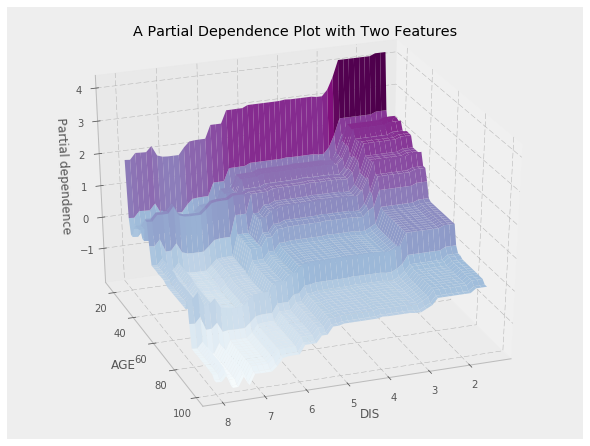

In [103]:
pdp, (x_axis, y_axis) = partial_dependence(model, (fidxs[1], fidxs[3]),
                                           X=X_train, grid_resolution=50)

fig = plt.figure()
plt.style.use('bmh')

XX, YY = np.meshgrid(x_axis, y_axis)
Z = pdp.T.reshape(XX.shape)
ax = Axes3D(fig)
ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu)
ax.view_init(elev=30, azim=70)
ax.set_xlabel(fnames[1])
ax.set_ylabel(fnames[3])
ax.set_zlabel('Partial dependence')
ax.set_title("A Partial Dependence Plot with Two Features")
plt.savefig('plots/patial-dependence-plot-two-features-with-interaction.png', bbox_inches='tight')

In [104]:
# Set style back
plt.style.use('ggplot')

In [105]:
# Tuning by cross validation
N_ESTIMATORS = 4000
N_FOLDS = 10

train_scores = np.zeros((N_FOLDS, N_ESTIMATORS))
test_scores = np.zeros((N_FOLDS, N_ESTIMATORS))

for k, (train_idxs, test_idxs) in enumerate(KFold(n=X.shape[0], n_folds=N_FOLDS,
                                            shuffle=True, random_state=1)):
    X_train, y_train = X[train_idxs, :], y[train_idxs]
    X_test, y_test = X[test_idxs, :], y[test_idxs]
    model = GradientBoostingRegressor(n_estimators=N_ESTIMATORS, learning_rate=0.01)
    model.fit(X_train, y_train)
    for i, y_pred in enumerate(model.staged_predict(X_train)):
        train_scores[k, i] = model.loss_(y_train, y_pred)
    for i, y_pred in enumerate(model.staged_predict(X_test)):
        test_scores[k, i] = model.loss_(y_test, y_pred)
        
mean_train_score = np.mean(train_scores, axis=0)
mean_test_score = np.mean(test_scores, axis=0)

optimal_n_trees = np.argmin(mean_test_score)
optimal_score = mean_test_score[optimal_n_trees]
optimal_point = (optimal_n_trees, optimal_score)

TypeError: __init__() got an unexpected keyword argument 'n_folds'

In [ ]:
for i in xrange(N_FOLDS):
    plt.plot(np.arange(N_ESTIMATORS) + 1, train_scores[i, :], color='red', alpha=0.25)
    
for i in xrange(N_FOLDS):
    plt.plot(np.arange(N_ESTIMATORS) + 1, test_scores[i, :], color='blue', alpha=0.25)
    
plt.plot(np.arange(N_ESTIMATORS) + 1, mean_test_score, color='blue', linewidth=2,
         label='Average Validation Fold Error')
plt.plot(np.arange(N_ESTIMATORS) + 1, mean_train_score, color='red', linewidth=2,
         label='Average Training Fold Error')

plt.annotate('Optimal Cross Validation Error', optimal_point,
              xytext=(optimal_point[0] - 1000, optimal_point[1] + 3),
              arrowprops=dict(facecolor="darkgrey", shrink=0.05),
              fontsize=14,
              alpha=0.75
            )

plt.title("Cross Validation Training and Testing Scores (10 folds)")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)
plt.legend(loc="upper right")
plt.ylim([0, 20])

plt.savefig('plots/training-and-testing-cv-error.png', bbox_inches='tight')

In [ ]:
# Varying the learning rate
N_ESTIMATORS = 1000
N_FOLDS = 10

learning_rates = [1, 0.5, 0.1, 0.025, 0.01]
N_LEARNING_RATES = len(learning_rates)

train_scores = np.zeros((N_FOLDS, N_LEARNING_RATES, N_ESTIMATORS))
test_scores = np.zeros((N_FOLDS, N_LEARNING_RATES, N_ESTIMATORS))

for k, (train_idxs, test_idxs) in enumerate(KFold(n=X.shape[0], n_folds=N_FOLDS,
                                            shuffle=True, random_state=1)):
    X_train, y_train = X[train_idxs, :], y[train_idxs]
    X_test, y_test = X[test_idxs, :], y[test_idxs]

    models = [GradientBoostingRegressor(n_estimators=N_ESTIMATORS,
                                        max_depth=3, learning_rate=lr, subsample=0.5,
                                        random_state=154) 
              for lr in learning_rates]
    for model in models:
        model.fit(X_train, y_train)
    
    for i, model in enumerate(models):
        for j, y_pred in enumerate(model.staged_predict(X_train)):
            train_scores[k, i, j] = model.loss_(y_train, y_pred)
        
    for i, model in enumerate(models):
        for j, y_pred in enumerate(model.staged_predict(X_test)):
            test_scores[k, i, j] = model.loss_(y_test, y_pred)

mean_train_scores = np.mean(train_scores, axis=0)
mean_test_scores = np.mean(test_scores, axis=0)
            
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, 
                         figsize=(18.0, 8.0))
        
for i, rate in enumerate(learning_rates):        
    axes[0].plot(np.arange(N_ESTIMATORS) + 1, mean_train_scores[i, :], 
                 color=plt.cm.copper(float(i) / 10 + 0.5),
                 label="Learning Rate = " + str(rate))
axes[0].legend(loc="upper right")
axes[0].set_title("Training Data")
axes[0].set_xlabel('Number of Boosting Stages', fontsize=14)
axes[0].set_ylabel('Average Squared Error', fontsize=14)

for i, rate in enumerate(learning_rates):        
    axes[1].plot(np.arange(N_ESTIMATORS) + 1, mean_test_scores[i, :], 
                 color=plt.cm.copper(float(i) / 10 + 0.5),
                 label="Learning Rate = " + str(rate))
axes[1].legend(loc="upper right")
axes[1].set_title("Testing Data")
axes[1].set_xlabel('Number of Boosting Stages', fontsize=14)
axes[1].set_ylabel('Average Squared Error', fontsize=14)

plt.ylim([0, 20])
plt.suptitle("Effect of Varying the Learning Rate", fontsize=20)

plt.savefig('plots/varying-learning-rate-error.png', bbox_inches='tight')

In [ ]:
# Varying the learning rate
N_ESTIMATORS = 1000
N_FOLDS = 10

learning_rates = [1, 0.5, 0.1, 0.025, 0.01]
N_LEARNING_RATES = len(learning_rates)

train_scores = np.zeros((N_FOLDS, N_LEARNING_RATES, N_ESTIMATORS))

for k, (train_idxs, test_idxs) in enumerate(KFold(n=X.shape[0], n_folds=N_FOLDS,
                                            shuffle=True, random_state=1)):
    X_train, y_train = X[train_idxs, :], y[train_idxs]
    X_test, y_test = X[test_idxs, :], y[test_idxs]

    models = [GradientBoostingRegressor(n_estimators=N_ESTIMATORS,
                                        max_depth=3, learning_rate=lr, subsample=0.5,
                                        random_state=154) 
              for lr in learning_rates]
    for model in models:
        model.fit(X_train, y_train)
        
    for i, model in enumerate(models):
        for j, y_pred in enumerate(model.staged_predict(X_train)):
            train_scores[k, i, j] = model.loss_(y_train, y_pred)

mean_train_scores = np.mean(train_scores, axis=0)
        
for i, rate in enumerate(learning_rates):        
    plt.plot(np.arange(N_ESTIMATORS) + 1, mean_train_scores[i, :], 
                 color=plt.cm.copper(float(i) / 10 + 0.5),
                 label="Learning Rate = " + str(rate))
plt.legend(loc="upper right")
plt.title("Effect of Varying the Learning Rate on Training Error")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)

plt.ylim([0, 20])
plt.savefig('plots/varying-learning-rate-error-training.png', bbox_inches='tight')

In [ ]:
# Varying the learning rate
N_ESTIMATORS = 4000
N_FOLDS = 10

learning_rates = [1, 0.5, 0.1, 0.025, 0.01]
N_LEARNING_RATES = len(learning_rates)

test_scores = np.zeros((N_FOLDS, N_LEARNING_RATES, N_ESTIMATORS))

for k, (train_idxs, test_idxs) in enumerate(KFold(n=X.shape[0], n_folds=N_FOLDS,
                                            shuffle=True, random_state=1)):
    X_train, y_train = X[train_idxs, :], y[train_idxs]
    X_test, y_test = X[test_idxs, :], y[test_idxs]

    models = [GradientBoostingRegressor(n_estimators=N_ESTIMATORS,
                                        max_depth=3, learning_rate=lr, subsample=0.5,
                                        random_state=154) 
              for lr in learning_rates]
    for model in models:
        model.fit(X_train, y_train)
        
    for i, model in enumerate(models):
        for j, y_pred in enumerate(model.staged_predict(X_test)):
            test_scores[k, i, j] = model.loss_(y_test, y_pred)

mean_test_scores = np.mean(test_scores, axis=0)
        
for i, rate in enumerate(learning_rates):        
    plt.plot(np.arange(N_ESTIMATORS) + 1, mean_test_scores[i, :], 
                 color=plt.cm.copper(float(i) / 10 + 0.5),
                 label="Learning Rate = " + str(rate))
plt.legend(loc="upper right")
plt.title("Effect of Varying the Learning Rate on Cross Validation Error Rate")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)

plt.ylim([0, 20])
plt.savefig('plots/varying-learning-rate-error-testing.png', bbox_inches='tight')

In [ ]:
for i, rate in enumerate(learning_rates):        
    plt.plot(np.arange(N_ESTIMATORS) + 1, mean_test_scores[i, :], 
                 color=plt.cm.copper(float(i) / 10 + 0.5),
                 label="Learning Rate = " + str(rate))
plt.legend(loc="upper right")
plt.title("Effect of Varying Learning Rate on Cross Validation Error")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)

plt.xlim([0, 300])
plt.savefig('plots/varying-learning-rate-error-testing-zoom-start.png', bbox_inches='tight')

In [ ]:
for i, rate in enumerate(learning_rates):        
    plt.plot(np.arange(N_ESTIMATORS) + 1, mean_test_scores[i, :], 
                 color=plt.cm.copper(float(i) / 10 + 0.5),
                 label="Learning Rate = " + str(rate))
plt.legend(loc="upper right")
plt.title("Effect of Varying Learning Rate on Cross Validation Error")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)

plt.xlim([3500, 4000])
plt.ylim([8, 10])
plt.savefig('plots/varying-learning-rate-error-testing-zoom-end.png', bbox_inches='tight')

In [ ]:
# Varying the tree depth rate
N_ESTIMATORS = 4000
N_FOLDS = 10

tree_depths = [1, 3, 5, 7, 9]
N_TREE_DEPTHS = len(tree_depths)

test_scores = np.zeros((N_FOLDS, N_TREE_DEPTHS, N_ESTIMATORS))

for k, (train_idxs, test_idxs) in enumerate(KFold(n=X.shape[0], n_folds=N_FOLDS,
                                            shuffle=True, random_state=1)):
    X_train, y_train = X[train_idxs, :], y[train_idxs]
    X_test, y_test = X[test_idxs, :], y[test_idxs]

    models = [GradientBoostingRegressor(n_estimators=N_ESTIMATORS,
                                        max_depth=td, learning_rate=0.01, subsample=0.5,
                                        random_state=154)
              for td in tree_depths]
    for model in models:
        model.fit(X_train, y_train)
        
    for i, model in enumerate(models):
        for j, y_pred in enumerate(model.staged_predict(X_test)):
            test_scores[k, i, j] = model.loss_(y_test, y_pred)
        
mean_test_scores = np.mean(test_scores, axis=0)

for i, depth in enumerate(tree_depths):        
    plt.plot(np.arange(N_ESTIMATORS) + 1, mean_test_scores[i, :], 
                 color=plt.cm.copper(float(i) / 10 + 0.5),
                 label="Tree Depth " + str(depth))
plt.legend(loc="upper right")
plt.title("Effect of Varying the Tree Depth on Cross Validation Error")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)

plt.ylim([0, 40])
plt.savefig('plots/varying-tree-depth-error.png', bbox_inches='tight')

In [ ]:
for i, depth in enumerate(tree_depths):        
    plt.plot(np.arange(N_ESTIMATORS) + 1, mean_test_scores[i, :], 
                 color=plt.cm.copper(float(i) / 10 + 0.5),
                 label="Tree Depth = " + str(depth))
plt.legend(loc="upper right")
plt.title("Effect of Varying the Tree Depth on Cross Validation Error")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)

plt.xlim([3500, 4000])
plt.ylim([8, 10])
plt.savefig('plots/varying-tree-depth-error-zoom.png', bbox_inches='tight')

In [ ]:
# Varying the subsample rate
N_ESTIMATORS = 4000
N_FOLDS = 10

subsample_rates = [1, 0.8, 0.6, 0.4, 0.2]
N_SUBSAMPLE_RATES = len(subsample_rates)

test_scores = np.zeros((N_FOLDS, N_SUBSAMPLE_RATES, N_ESTIMATORS))

for k, (train_idxs, test_idxs) in enumerate(KFold(n=X.shape[0], n_folds=N_FOLDS,
                                            shuffle=True, random_state=1)):
    X_train, y_train = X[train_idxs, :], y[train_idxs]
    X_test, y_test = X[test_idxs, :], y[test_idxs]

    models = [GradientBoostingRegressor(n_estimators=N_ESTIMATORS,
                                        max_depth=3, learning_rate=0.01, subsample=sr,
                                        random_state=154)
              for sr in subsample_rates]
    for model in models:
        model.fit(X_train, y_train)
        
    for i, model in enumerate(models):
        for j, y_pred in enumerate(model.staged_predict(X_test)):
            test_scores[k, i, j] = model.loss_(y_test, y_pred)
        
mean_test_scores = np.mean(test_scores, axis=0)

for i, rate in enumerate(subsample_rates):        
    plt.plot(np.arange(N_ESTIMATORS) + 1, mean_test_scores[i, :], 
                 color=plt.cm.copper(float(i) / 10 + 0.5),
                 label="Subsample Rate " + str(rate))
plt.legend(loc="upper right")
plt.title("Effect of Varying the Subsample Rate on Cross Validation Error.")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)

plt.ylim([0, 20])
plt.savefig('plots/varying-subsample-rate-error.png', bbox_inches='tight')

In [ ]:
for i, rate in enumerate(subsample_rates):        
    plt.plot(np.arange(N_ESTIMATORS) + 1, mean_test_scores[i, :], 
                 color=plt.cm.copper(float(i) / 10 + 0.5),
                 label="Subsample Rate " + str(rate))
plt.legend(loc="upper right")
plt.title("Effect of Varying the Subsample Rate on Cross Validation Error.")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)

plt.ylim([0, 20])
plt.xlim([0, 1000])
plt.savefig('plots/varying-subsample-rate-error-zoom-start.png', bbox_inches='tight')

In [ ]:
for i, rate in enumerate(subsample_rates):        
    plt.plot(np.arange(N_ESTIMATORS) + 1, mean_test_scores[i, :], 
                 color=plt.cm.copper(float(i) / 10 + 0.5),
                 label="Subsample Rate " + str(rate))
plt.legend(loc="upper right")
plt.title("Effect of Varying the Subsample Rate on Cross Validation Error.")
plt.xlabel('Number of Boosting Stages', fontsize=14)
plt.ylabel('Average Squared Error', fontsize=14)

plt.ylim([8, 12])
plt.xlim([3500, 4000])
plt.savefig('plots/varying-subsample-rate-error-zoom-end.png', bbox_inches='tight')

## Loss function plots.

In [ ]:
# Logistic loss.
x = np.linspace(-2, 2, 200)
one_branch =  - x + np.log(1 + np.exp(x))
zero_branch = np.log(1 + np.exp(x))

plt.plot(x, one_branch, label="Loss when $y=1$")
plt.plot(x, zero_branch, label="Loss when $y=0$")

plt.legend(loc="upper right")
plt.title("Logistic Loss Function")
plt.xlabel('$f$ (Predicted Log Odds)', fontsize=14)
plt.ylabel('Logistic Loss', fontsize=14)
plt.savefig('plots/loss-function-logistic.png', bbox_inches='tight')

In [ ]:
# Adaboost Exponential Loss

x = np.linspace(-2, 2, 200)
one_branch =  np.exp(-x)
zero_branch = np.exp(x)

plt.plot(x, one_branch, label="Loss when $y=1$")
plt.plot(x, zero_branch, label="Loss when $y=0$")

plt.legend(loc="upper right")
plt.title("Exponential Loss Function (Adaboost)")
plt.xlabel('$f$', fontsize=14)
plt.ylabel('Exponential Loss', fontsize=14)

plt.savefig('plots/loss-function-adaboost.png', bbox_inches='tight')

In [ ]:
# Comparison
# Logistic loss.
x = np.linspace(-2, 2, 200)
logistic_branch =  - x + np.log(1 + np.exp(x))
adaboost_branch = np.exp(-x)

plt.plot(x, logistic_branch, label="Logistic Loss when $y=1$")
plt.plot(x, adaboost_branch, label="Exponential Loss when $y=1$")

plt.legend(loc="upper right")
plt.title("Logistic and Exponential Loss Comparison")
plt.xlabel('$f$', fontsize=14)
plt.ylabel('Logistic Loss', fontsize=14)

plt.savefig('plots/loss-function-comparison.png', bbox_inches='tight')

In [ ]:
model.n